# Classify structured data using Keras Preprocessing Layers

## 1. The Dataset

## 2. Import TensorFlow and other libraries

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print("The version of Tensorflow: {}".format(tf.__version__))

The version of Tensorflow: 2.4.1


## 3. Use Pandas to create a dataframe

In [2]:
import pathlib

dataset_url = 'http://storage.googleapis.com/download.tensorflow.org/data/petfinder-mini.zip'
csv_file = 'datasets/petfinder-mini/petfinder-mini.csv'

tf.keras.utils.get_file('petfinder_mini.zip', dataset_url,
                        extract=True, cache_dir='.')
dataframe = pd.read_csv(csv_file)

In [3]:
dataframe.head()

,Type,Age,Breed1,Gender,Color1,Color2,MaturitySize,FurLength,Vaccinated,Sterilized,Health,Fee,Description,PhotoAmt,AdoptionSpeed
0,Cat,3,Tabby,Male,Black,White,Small,Short,No,No,Healthy,100,Nibble is a 3+ month old ball of cuteness. He ...,1,2
1,Cat,1,Domestic Medium Hair,Male,Black,Brown,Medium,Medium,Not Sure,Not Sure,Healthy,0,I just found it alone yesterday near my apartm...,2,0
2,Dog,1,Mixed Breed,Male,Brown,White,Medium,Medium,Yes,No,Healthy,0,Their pregnant mother was dumped by her irresp...,7,3
3,Dog,4,Mixed Breed,Female,Black,Brown,Medium,Short,Yes,No,Healthy,150,"Good guard dog, very alert, active, obedience ...",8,2
4,Dog,1,Mixed Breed,Male,Black,No Color,Medium,Short,No,No,Healthy,0,This handsome yet cute boy is up for adoption....,3,2


In [5]:
dataframe.dtypes

Type             object
Age               int64
Breed1           object
Gender           object
Color1           object
Color2           object
MaturitySize     object
FurLength        object
Vaccinated       object
Sterilized       object
Health           object
Fee               int64
Description      object
PhotoAmt          int64
AdoptionSpeed     int64
dtype: object

## 4. Create target variable

In [6]:
# In the original dataset "4" indicates the pet was not adopted.
dataframe['target'] = np.where(dataframe['AdoptionSpeed']==4, 0, 1)

# Drop un-used columns.
dataframe = dataframe.drop(columns=['AdoptionSpeed', 'Description'])

## 5. Split the dataframe into train, validation, and test

In [7]:
train, test = train_test_split(dataframe, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

7383 train examples
1846 validation examples
2308 test examples


## 6. Create an input pipeline using tf.data

In [8]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('target')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

In [9]:
# Now that you have created the input pipeline, let's call it to see the format of the data it returns. 
# You have used a small batch size to keep the output readable.

batch_size = 5
train_ds = df_to_dataset(train, batch_size=batch_size)

In [10]:
[(train_features, label_batch)] = train_ds.take(1)
print('Every feature:', list(train_features.keys()))
print('A batch of ages:', train_features['Age'])
print('A batch of targets:', label_batch )

Every feature: ['Type', 'Age', 'Breed1', 'Gender', 'Color1', 'Color2', 'MaturitySize', 'FurLength', 'Vaccinated', 'Sterilized', 'Health', 'Fee', 'PhotoAmt']
A batch of ages: tf.Tensor([24  3  1  3  2], shape=(5,), dtype=int64)
A batch of targets: tf.Tensor([0 1 1 1 1], shape=(5,), dtype=int32)


## 7. Demonstrate the use of preprocessing layers.

### i. Numeric columns

In [12]:
def get_normalization_layer(name, dataset):
  # Create a Normalization layer for our feature.
  normalizer = preprocessing.Normalization()

  # Prepare a Dataset that only yields our feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the statistics of the data.
  normalizer.adapt(feature_ds)

  return normalizer

In [13]:
photo_count_col = train_features['PhotoAmt']
layer = get_normalization_layer('PhotoAmt', train_ds)
layer(photo_count_col)

<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[-0.18662721],
       [-0.5023625 ],
       [-0.8180978 ],
       [-0.5023625 ],
       [ 0.76057863]], dtype=float32)>

### ii. Categorical columns

In [14]:
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
  # Create a StringLookup layer which will turn strings into integer indices
  if dtype == 'string':
    index = preprocessing.StringLookup(max_tokens=max_tokens)
  else:
    index = preprocessing.IntegerLookup(max_values=max_tokens)

  # Prepare a Dataset that only yields our feature
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the set of possible values and assign them a fixed integer index.
  index.adapt(feature_ds)

  # Create a Discretization for our integer indices.
  encoder = preprocessing.CategoryEncoding(max_tokens=index.vocab_size())

  # Prepare a Dataset that only yields our feature.
  feature_ds = feature_ds.map(index)

  # Learn the space of possible indices.
  encoder.adapt(feature_ds)

  # Apply one-hot encoding to our indices. The lambda function captures the
  # layer so we can use them, or include them in the functional model later.
  return lambda feature: encoder(index(feature))

In [15]:
type_col = train_features['Type']
layer = get_category_encoding_layer('Type', train_ds, 'string')
layer(type_col)

<tf.Tensor: shape=(5, 4), dtype=float32, numpy=
array([[0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]], dtype=float32)>

In [16]:
# Often, you don't want to feed a number directly into the model, 
# but instead use a one-hot encoding of those inputs. 
# Consider raw data that represents a pet's age.

type_col = train_features['Age']
category_encoding_layer = get_category_encoding_layer('Age', train_ds,
                                                      'int64', 5)
category_encoding_layer(type_col)

<tf.Tensor: shape=(5, 5), dtype=float32, numpy=
array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)>

## 8. Choose which columns to use

In [17]:
# Earlier, you used a small batch size to demonstrate the input pipeline. 
# Let's now create a new input pipeline with a larger batch size.


batch_size = 256
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

In [18]:
all_inputs = []
encoded_features = []

# Numeric features.
for header in ['PhotoAmt', 'Fee']:
  numeric_col = tf.keras.Input(shape=(1,), name=header)
  normalization_layer = get_normalization_layer(header, train_ds)
  encoded_numeric_col = normalization_layer(numeric_col)
  all_inputs.append(numeric_col)
  encoded_features.append(encoded_numeric_col)

In [19]:
# Categorical features encoded as integers.
age_col = tf.keras.Input(shape=(1,), name='Age', dtype='int64')
encoding_layer = get_category_encoding_layer('Age', train_ds, dtype='int64',
                                             max_tokens=5)
encoded_age_col = encoding_layer(age_col)
all_inputs.append(age_col)
encoded_features.append(encoded_age_col)

In [20]:
# Categorical features encoded as string.
categorical_cols = ['Type', 'Color1', 'Color2', 'Gender', 'MaturitySize',
                    'FurLength', 'Vaccinated', 'Sterilized', 'Health', 'Breed1']
for header in categorical_cols:
  categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
  encoding_layer = get_category_encoding_layer(header, train_ds, dtype='string',
                                               max_tokens=5)
  encoded_categorical_col = encoding_layer(categorical_col)
  all_inputs.append(categorical_col)
  encoded_features.append(encoded_categorical_col)

## 9. Create, compile, and train the model

In [21]:
# Now you can create our end-to-end model

all_features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(32, activation="relu")(all_features)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(all_inputs, output)
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=["accuracy"])

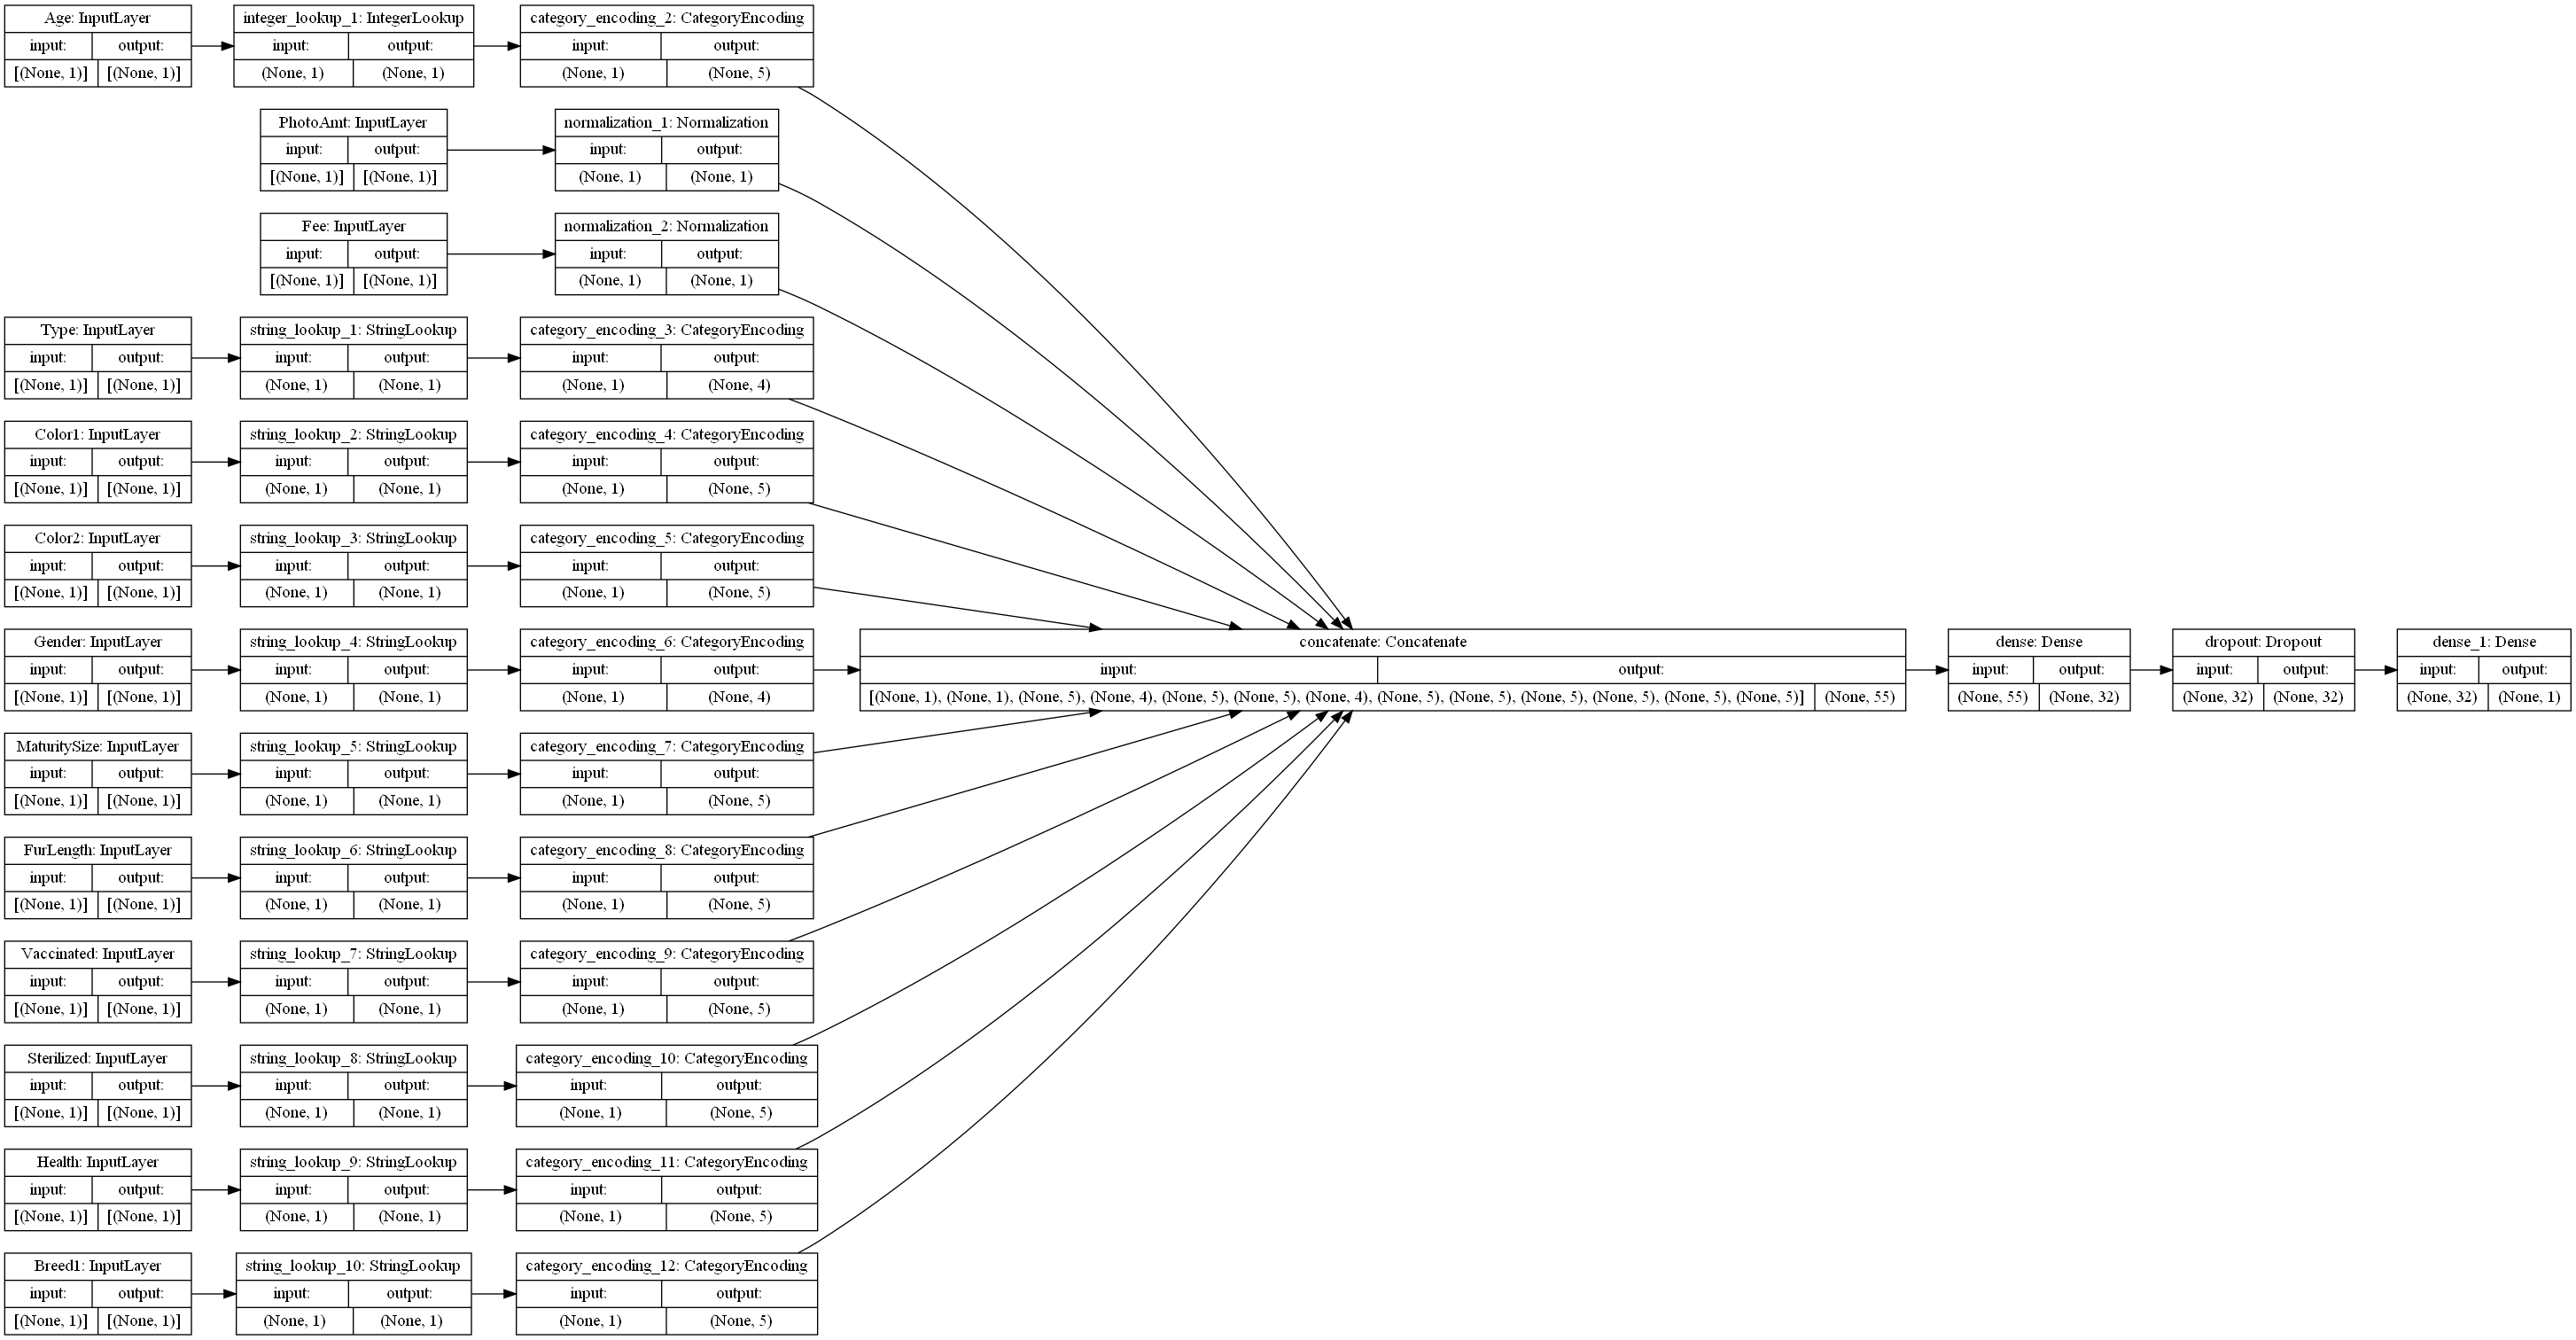

In [22]:
# Let's visualize our connectivity graph

# rankdir='LR' is used to make the graph horizontal.
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

### i. Train the model

In [23]:
model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
29/29 [==============================] - 2s 24ms/step - loss: 0.6360 - accuracy: 0.5152 - val_loss: 0.5512 - val_accuracy: 0.7226
Epoch 2/10
29/29 [==============================] - 0s 11ms/step - loss: 0.5944 - accuracy: 0.6563 - val_loss: 0.5355 - val_accuracy: 0.7443
Epoch 3/10
29/29 [==============================] - 0s 11ms/step - loss: 0.5619 - accuracy: 0.6789 - val_loss: 0.5268 - val_accuracy: 0.7486
Epoch 4/10
29/29 [==============================] - 0s 11ms/step - loss: 0.5440 - accuracy: 0.6979 - val_loss: 0.5216 - val_accuracy: 0.7449
Epoch 5/10
29/29 [==============================] - 0s 11ms/step - loss: 0.5597 - accuracy: 0.6927 - val_loss: 0.5168 - val_accuracy: 0.7470
Epoch 6/10
29/29 [==============================] - 0s 11ms/step - loss: 0.5477 - accuracy: 0.7075 - val_loss: 0.5140 - val_accuracy: 0.7378
Epoch 7/10
29/29 [==============================] - 0s 11ms/step - loss: 0.5408 - accuracy: 0.7109 - val_loss: 0.5108 - val_accuracy: 0.7356
Epoch 8/10
29

In [24]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)

10/10 [==============================] - 0s 8ms/step - loss: 0.4864 - accuracy: 0.7639
Accuracy 0.7638648152351379


## 10. Inference on new data

In [26]:
# Key Point: The model you have developed can now classify a row from a CSV file directly, 
# because the preprocessing code is included inside the model itself.


# You can now save and reload the Keras model. Follow the tutorial here for more information on TensorFlow models.

model.save('my_pet_classifier')
reloaded_model = tf.keras.models.load_model('my_pet_classifier')

INFO:tensorflow:Assets written to: my_pet_classifier\assets


In [27]:
sample = {
    'Type': 'Cat',
    'Age': 3,
    'Breed1': 'Tabby',
    'Gender': 'Male',
    'Color1': 'Black',
    'Color2': 'White',
    'MaturitySize': 'Small',
    'FurLength': 'Short',
    'Vaccinated': 'No',
    'Sterilized': 'No',
    'Health': 'Healthy',
    'Fee': 100,
    'PhotoAmt': 2,
}

input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
predictions = reloaded_model.predict(input_dict)
prob = tf.nn.sigmoid(predictions[0])

print(
    "This particular pet had a %.1f percent probability "
    "of getting adopted." % (100 * prob)
)

This particular pet had a 82.2 percent probability of getting adopted.


# reference

### https://tensorflow.google.cn/tutorials/structured_data/preprocessing_layers#inference_on_new_data